<a href="https://colab.research.google.com/github/jellydaniellie/cs6501-final/blob/main/DSweekly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

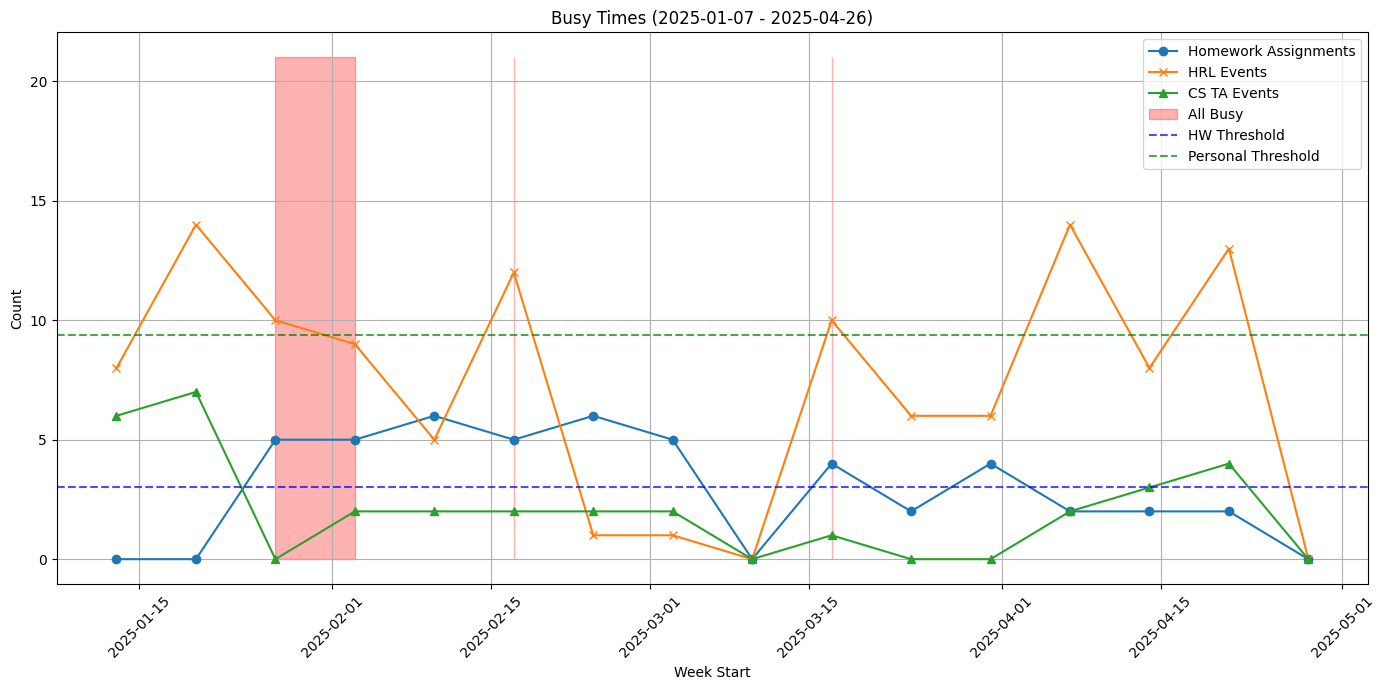


Sample Busy Weeks:
  Week Start  Busy Academic  Busy Personal  Busy Both
0 2025-01-13              0              1          0
1 2025-01-20              0              1          0
2 2025-01-27              1              1          1
3 2025-02-03              1              1          1
4 2025-02-10              1              0          0
5 2025-02-17              1              1          1
6 2025-02-24              1              0          0
7 2025-03-03              1              0          0
8 2025-03-10              0              0          0
9 2025-03-17              1              1          1


In [ ]:
!pip install icalendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import icalendar
from datetime import datetime, timedelta
import os

# -------------------- SETTINGS --------------------
HOMEWORK_CSV = "/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/HomeworkTracker.csv"
HRL_CALENDAR_ICS = "/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/HRL.ics"
CS_CALENDAR_ICS = "/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/CS 111x.ics"
CALENDAR_ICS = 'combined_calendar.ics'
START_DATE = "2025-01-07"               # Semester start date
END_DATE = "2025-04-26"                 # Semester end date
BUSY_HW_THRESHOLD = "mean"              # "mean", "median", or a fixed number
BUSY_PERSONAL_THRESHOLD = "mean"         # "mean", "median", or a fixed number
# ---------------------------------------------------


def load_homework(csv_path, start_date, end_date):
  df = pd.read_csv(csv_path)
  df['Due date'] = pd.to_datetime(df['Due date'], errors='coerce')
  df = df[(df['Due date'] >= start_date) & (df['Due date'] <= end_date)]
  df['Week Start'] = df['Due date'].dt.to_period('W').apply(lambda r: r.start_time)

  major_task_types = ['Quiz', 'Presentation', 'Exam', 'Paper']
  hw_counts = df.loc[~df['Task type'].isin(major_task_types)].groupby('Week Start').size()
  major_counts = df.loc[df['Task type'].isin(major_task_types)].groupby('Week Start').size()
  return hw_counts, major_counts

def load_calendar(ics_path, start_date, end_date):
  with open(ics_path, 'rb') as f:
    cal = icalendar.Calendar.from_ical(f.read())

  events = []
  for component in cal.walk():
      if component.name == "VEVENT":
        dtstart = component.get('dtstart').dt
        if isinstance(dtstart, datetime):
          dtstart = pd.Timestamp(dtstart).tz_localize(None)
          if start_date <= dtstart <= end_date:
              events.append(dtstart)

  df = pd.DataFrame({'Start': events})
  df['Week Start'] = df['Start'].dt.to_period('W').apply(lambda r: r.start_time)
  personal_counts = df.groupby('Week Start').size()
  return personal_counts

def determine_busy_weeks(counts, threshold_rule):
  if threshold_rule == "mean":
    threshold = counts.mean()
  elif threshold_rule == "median":
    threshold = counts.median()
  else:
    threshold = float(threshold_rule)
  return counts > threshold, threshold


start_date = pd.to_datetime(START_DATE)
end_date = pd.to_datetime(END_DATE)

hw_counts, major_counts = load_homework(HOMEWORK_CSV, start_date, end_date)

hrl_counts = load_calendar(HRL_CALENDAR_ICS, start_date, end_date)

cs_counts = load_calendar(CS_CALENDAR_ICS, start_date, end_date)

personal_counts = hrl_counts + cs_counts

weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')
weeks = weeks.union([weeks[-1] + timedelta(days=7)])

combined = pd.DataFrame({'Week Start': weeks})
combined['Homework Assignments'] = combined['Week Start'].map(hw_counts).fillna(0)
combined['Major Assignments'] = combined['Week Start'].map(major_counts).fillna(0)

combined['HRL Events'] = combined['Week Start'].map(hrl_counts).fillna(0)
combined['CS Events'] = combined['Week Start'].map(cs_counts).fillna(0)
combined['Personal Events'] = combined['HRL Events'] + combined['CS Events']

combined['Homework Assignments'] = combined['Homework Assignments'].astype(int)
combined['Major Assignments'] = combined['Major Assignments'].astype(int)

combined['HRL Events'] = combined['HRL Events'].astype(int)
combined['CS Events'] = combined['CS Events'].astype(int)
combined['Personal Events'] = combined['Personal Events'].astype(int)

busy_academic, hw_threshold = determine_busy_weeks(combined['Homework Assignments'], BUSY_HW_THRESHOLD)
busy_personal, personal_threshold = determine_busy_weeks(combined['Personal Events'], BUSY_PERSONAL_THRESHOLD)


combined['Busy Academic'] = busy_academic.astype(int)
combined['Significant Assignments'] = combined['Major Assignments'].astype(bool).astype(int)

combined['Academic Pressure Week'] = (combined['Busy Academic'] | (combined['Significant Assignments'] > 0)).astype(int)

combined['Busy Personal'] = busy_personal.astype(int)
combined['Busy Both'] = combined['Busy Academic'] & combined['Busy Personal']

plt.figure(figsize=(14, 7))
plt.plot(combined['Week Start'], combined['Homework Assignments'], label='Homework Assignments', marker='o')
plt.plot(combined['Week Start'], combined['HRL Events'], label='HRL Events', marker='x')
plt.plot(combined['Week Start'], combined['CS Events'], label='CS TA Events', marker='^')

plt.fill_between(combined['Week Start'], 0, max(combined['Homework Assignments'].max(), combined['Personal Events'].max()),
                     where=combined['Busy Both'], color='red', alpha=0.3, label='All Busy')

plt.axhline(hw_threshold, color='blue', linestyle='--', alpha=0.7, label='HW Threshold')
plt.axhline(personal_threshold, color='green', linestyle='--', alpha=0.7, label='Personal Threshold')

plt.title('Busy Times ({} - {})'.format(START_DATE, END_DATE))
plt.xlabel('Week Start')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nSample Busy Weeks:")
print(combined[['Week Start', 'Busy Academic', 'Busy Personal', 'Busy Both']].head(10))


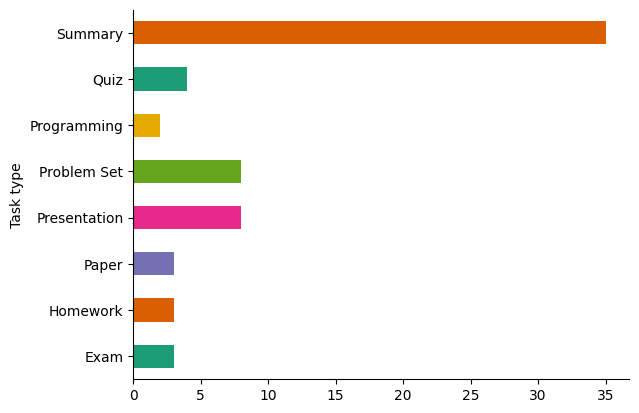

In [ ]:
# @title Task type

from matplotlib import pyplot as plt
import seaborn as sns
hw_df = pd.read_csv(HOMEWORK_CSV)
hw_df.groupby('Task type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

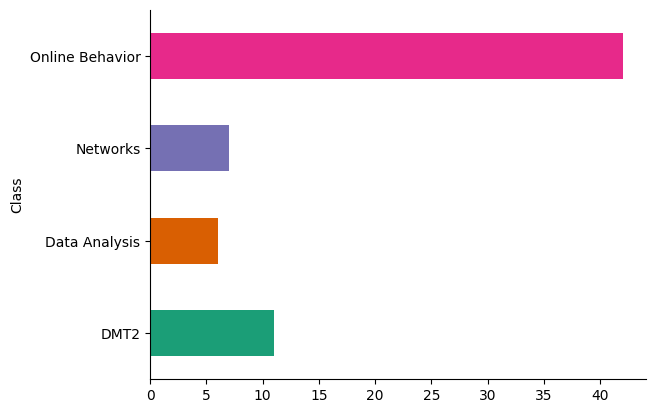

In [ ]:
# @title Class
from matplotlib import pyplot as plt
import seaborn as sns
hw_df.groupby('Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

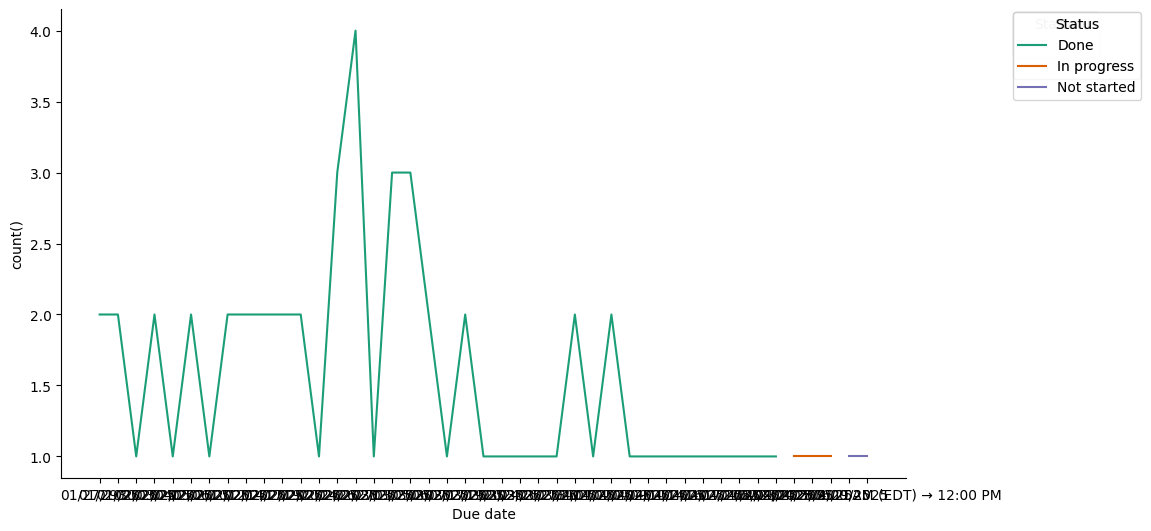

In [ ]:
# @title Due date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Due date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Due date'}, axis=1)
              .sort_values('Due date', ascending=True))
  xs = counted['Due date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hw_df.sort_values('Due date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Status')):
  _plot_series(series, series_name, i)
  fig.legend(title='Status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Due date')
_ = plt.ylabel('count()')

In [ ]:
import re
import csv
from datetime import datetime, timedelta
from collections import defaultdict
from bs4 import BeautifulSoup


start_date = datetime(2025, 1, 7)
end_date = datetime(2025, 4, 26)

# Initialize counters
day_counts = defaultdict(int)
week_counts = defaultdict(int)
month_counts = defaultdict(int)

# Read the HTML content
with open("/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/watch-history.html", "r", encoding="utf-8") as f:
    html_content = f.read()

# Find each outer block
entries = re.findall(r'<div class="outer-cell.*?mdl-shadow--2dp">(.*?)</div></div>', html_content, re.DOTALL)
print(f"Found {len(entries)} entries.")

for entry in entries:
    # Extract the "Watched" or "Viewed" action + video
    links = re.findall(r'<a href="([^"]+)">([^<]+)</a>', entry)

    video_url, video_title = None, None
    channel_url, channel_name = None, None

    if len(links) >= 1:
      video_url, video_title = links[0]  # first <a> is always the video
    if len(links) >= 2:
      channel_url, channel_name = links[1]  # second <a> is the channel

    # Extract timestamp
    timestamp_match = re.search(r'(\w{3} \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2}.*?(EDT|EST|UTC|PDT|PST))', entry) # Modified regex to capture the timezone
    timestamp_str = timestamp_match.group(1) if timestamp_match else None

    # Parse to datetime object, handling timezone
    try:
        timestamp_dt = datetime.strptime(timestamp_str, "%b %d, %Y, %I:%M:%S %p %Z") # Added %Z to parse timezone
    except ValueError:
        # If %Z fails, try without timezone (some entries might not have it)
        timestamp_dt = datetime.strptime(timestamp_str[:-4], "%b %d, %Y, %I:%M:%S %p") # Removed last 4 char for timezone and parsed.

    # Check if within range
    if start_date <= timestamp_dt <= end_date:
        #print(video_title, video_url, channel_name, channel_url, timestamp_dt)

        day_str = timestamp_dt.strftime("%Y-%m-%d")       # e.g., 2025-04-25
        month_str = timestamp_dt.strftime("%Y-%m")         # e.g., 2025-04

        week_start = timestamp_dt - timedelta(days=timestamp_dt.weekday())
        week_counts[week_start.date()] += 1

        day_counts[day_str] += 1

        month_counts[month_str] += 1

youtube_threshold = sum(list(day_counts.values())) / len(day_counts)
print('Threshold:', youtube_threshold)
youtube_weekly_threshold = sum(list(day_counts.values())) / (len(day_counts)/7)
print('Weekly Threshold:', youtube_weekly_threshold)

# Create DataFrame from daily counts
youtube_daily_df = pd.DataFrame(list(day_counts.items()), columns=['Date', 'watch_count'])
youtube_daily_df['Date'] = pd.to_datetime(youtube_daily_df['Date'])
youtube_daily_df = youtube_daily_df.sort_values('Date')

# Apply threshold to create binary series
youtube_daily_df['significant_spike'] = (youtube_daily_df['watch_count'] > youtube_threshold).astype(int)

# --- If you also want weekly, here is your weekly DataFrame ---
youtube_weekly_df = pd.DataFrame(list(week_counts.items()), columns=['Week Start', 'watch_count'])
youtube_weekly_df['Week Start'] = pd.to_datetime(youtube_weekly_df['Week Start'])
youtube_weekly_df = youtube_weekly_df.sort_values('Week Start')
youtube_weekly_df['Significant Spike'] = (youtube_weekly_df['watch_count'] > youtube_weekly_threshold).astype(int)

# Show first few rows
print(youtube_daily_df.head())
print(youtube_weekly_df.head())

Found 31378 entries.
Threshold: 55.87619047619047
Weekly Threshold: 391.1333333333333
          Date  watch_count  significant_spike
104 2025-01-07            2                  0
103 2025-01-09            6                  0
102 2025-01-10           26                  0
101 2025-01-11           29                  0
100 2025-01-12          350                  1
   Week Start  watch_count  Significant Spike
15 2025-01-06          413                  1
14 2025-01-13          162                  0
13 2025-01-20          288                  0
12 2025-01-27          280                  0
11 2025-02-03          186                  0


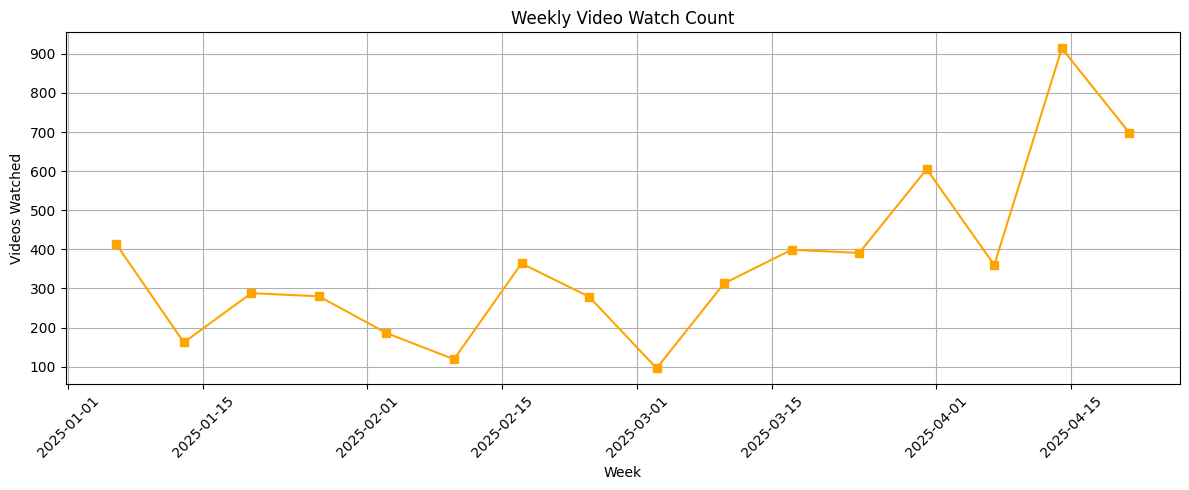

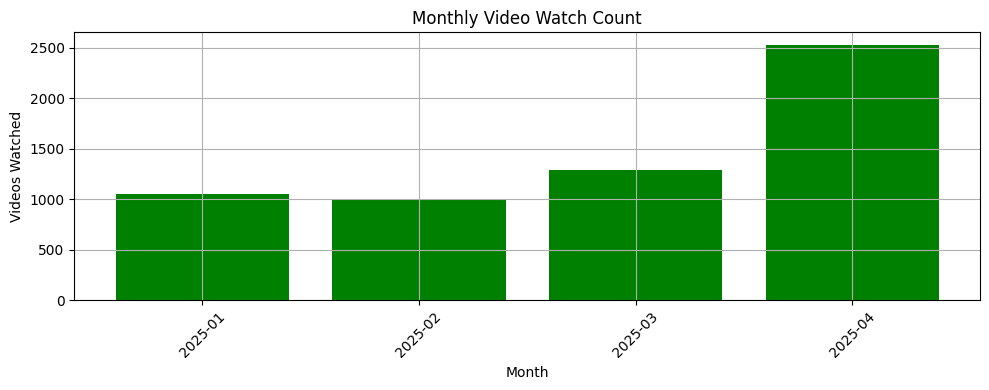

In [ ]:
import matplotlib.pyplot as plt

# Plot Daily Counts
# days = sorted(day_counts.keys())
# counts = [day_counts[day] for day in days]

# plt.figure(figsize=(14,6))
# plt.plot(days, counts, marker='o')
# plt.title('Daily Video Watch Count')
# plt.xlabel('Date')
# plt.ylabel('Videos Watched')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# weekly:
weeks = sorted(week_counts.keys())
week_counts_list = [week_counts[week] for week in weeks]

plt.figure(figsize=(12,5))
plt.plot(weeks, week_counts_list, marker='s', color='orange')
plt.title('Weekly Video Watch Count')
plt.xlabel('Week')
plt.ylabel('Videos Watched')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly:
months = sorted(month_counts.keys())
month_counts_list = [month_counts[month] for month in months]

plt.figure(figsize=(10,4))
plt.bar(months, month_counts_list, color='green')
plt.title('Monthly Video Watch Count')
plt.xlabel('Month')
plt.ylabel('Videos Watched')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#@title Food Spending
import pandas as pd
import matplotlib.pyplot as plt

location_dict = {'Chik-Fil-A - Grubhub - Kiosk': 'Chik-Fil-A',
                 'The Den - Grubhub - Kiosk': 'The Den',
                 'Grill at XRoads - Grubhub': 'Hoos Hot Chicken',
                 'XRoads C-Store-Micros SAAS':'Crossroads Convenience',
                 'Bento - Grubhub - Kiosk': 'Bento Sushi',
                 'Einsteins Rice - Grubhub - Kiosk': 'Einstein Bagels',
                 'Launch Kitchen - Grubhub - Kiosk': 'Launch Kitchen',
                 'POD Newcomb - Micros SAAS':'1819 Supply',
                 'Juice Laundry-AFC - Grubhub': 'Juice Laundry @ AFC',
                 "Shannon Lib. Saxby's - Grubhub": "Saxby's",
                 "Wilsdorf Greenberry's - Grubhub": "Greenberry's @ Wilsdorf",
                 'Got Dumplings - Grubhub': 'Got Dumplings'}

food_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/DiningDollarUsage.csv")
food_df['Date'] = pd.to_datetime(food_df['Date'])
food_df = food_df.drop('Balance',axis=1)
food_df['Amount'] = food_df['Amount'].str.replace('$', '').str.replace(',', '').astype(float)
food_df['Week Start'] = food_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
food_df['Location'] = food_df['Location'].replace(location_dict)

# Sum purchases weekly
weekly_food = food_df.groupby('Week Start')['Amount'].sum().rename('purchase_count').reset_index()

# Calculate mean purchase amount
mean_food = weekly_food['purchase_count'].mean()

# Create Purchase Spike binary indicator
weekly_food['Purchase Spike'] = (weekly_food['purchase_count'] > mean_food).astype(int)

# Rename final df
purchase_df = weekly_food

print(purchase_df.head())


  Week Start  purchase_count  Purchase Spike
0 2025-01-13           39.47               0
1 2025-01-20           32.96               0
2 2025-01-27           66.80               1
3 2025-02-03           59.71               1
4 2025-02-10           19.69               0


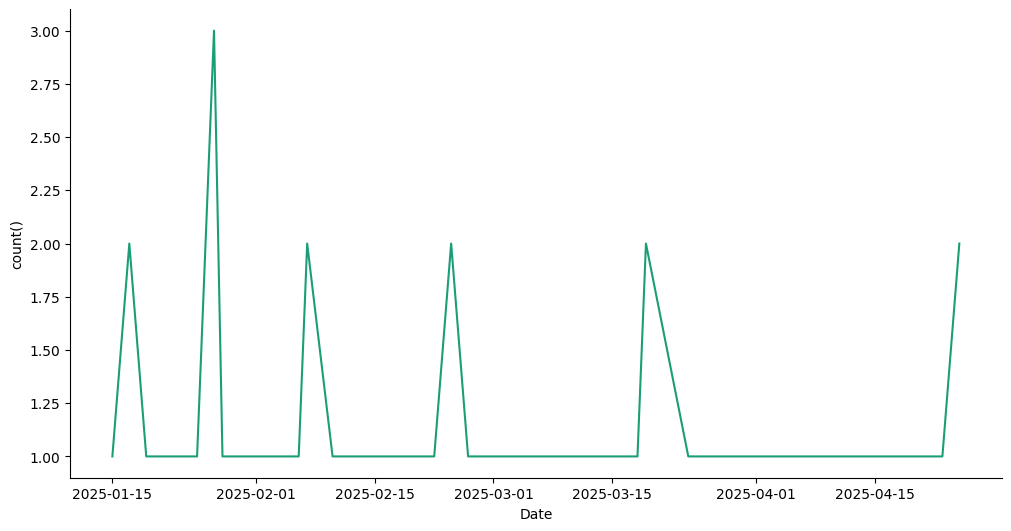

In [ ]:
# @title Date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = food_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

In [ ]:
import json
import pandas as pd

# Load JSON
with open('/content/drive/MyDrive/Colab Notebooks/online behavior final/des data/ds_life_events.json') as f:
    life_events = json.load(f)

# Convert to DataFrame
events_df = pd.DataFrame(life_events['events'])
events_df['date'] = pd.to_datetime(events_df['date'])

# Full date range (daily)
full_dates = pd.date_range(start='2025-01-01', end='2025-04-01')
binary_series = pd.DataFrame({'date': full_dates})

# Overall event occurrence
binary_series['event_occurred'] = binary_series['date'].isin(events_df['date']).astype(int)

# Unique event types
event_types = events_df['event'].unique()

# Add separate binary columns per event type
for event_type in event_types:
    dates_of_type = events_df.loc[events_df['event'] == event_type, 'date']
    binary_series[event_type] = binary_series['date'].isin(dates_of_type).astype(int)

# ➡️ Now move to weekly resolution:
binary_series['Week Start'] = binary_series['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and take the maximum (if any day has event, week is marked 1)
weekly_binary = binary_series.groupby('Week Start').max().reset_index()

print(weekly_binary.head())


  Week Start       date  event_occurred  start of classes  interview  holiday  \
0 2024-12-30 2025-01-05               0                 0          0        0   
1 2025-01-06 2025-01-12               0                 0          0        0   
2 2025-01-13 2025-01-19               1                 1          1        0   
3 2025-01-20 2025-01-26               1                 0          1        1   
4 2025-01-27 2025-02-02               0                 0          0        0   

   birthday  shelter-in-place  school break  illness  
0         0                 0             0        0  
1         0                 0             0        0  
2         0                 0             0        0  
3         0                 0             0        0  
4         0                 0             0        0  


In [ ]:
final_merged = pd.merge(combined, youtube_weekly_df, on='Week Start')
final_merged = pd.merge(final_merged, purchase_df, on='Week Start')
final_merged = pd.merge(final_merged, weekly_binary, on='Week Start')

# Select only binary columns you care about
columns_to_correlate = [
    'Busy Academic', 'Busy Personal', 'Significant Assignments',
    'Significant Spike', 'Purchase Spike', 'school break', 'illness'
]

# Subset the final merged dataframe
correlation_data = final_merged[columns_to_correlate]
correlation_matrix = correlation_data.corr(method='pearson')

print(correlation_matrix)


                         Busy Academic  Busy Personal  \
Busy Academic             1.000000e+00   9.813078e-18   
Busy Personal             9.813078e-18   1.000000e+00   
Significant Assignments   2.390457e-01  -5.070926e-01   
Significant Spike         3.162278e-01   0.000000e+00   
Purchase Spike            5.976143e-01   1.690309e-01   
school break             -1.581139e-01  -4.472136e-01   
illness                  -1.581139e-01  -4.472136e-01   

                         Significant Assignments  Significant Spike  \
Busy Academic                           0.239046           0.316228   
Busy Personal                          -0.507093           0.000000   
Significant Assignments                 1.000000           0.075593   
Significant Spike                       0.075593           1.000000   
Purchase Spike                          0.314286          -0.377964   
school break                            0.075593          -0.200000   
illness                                 0.5291

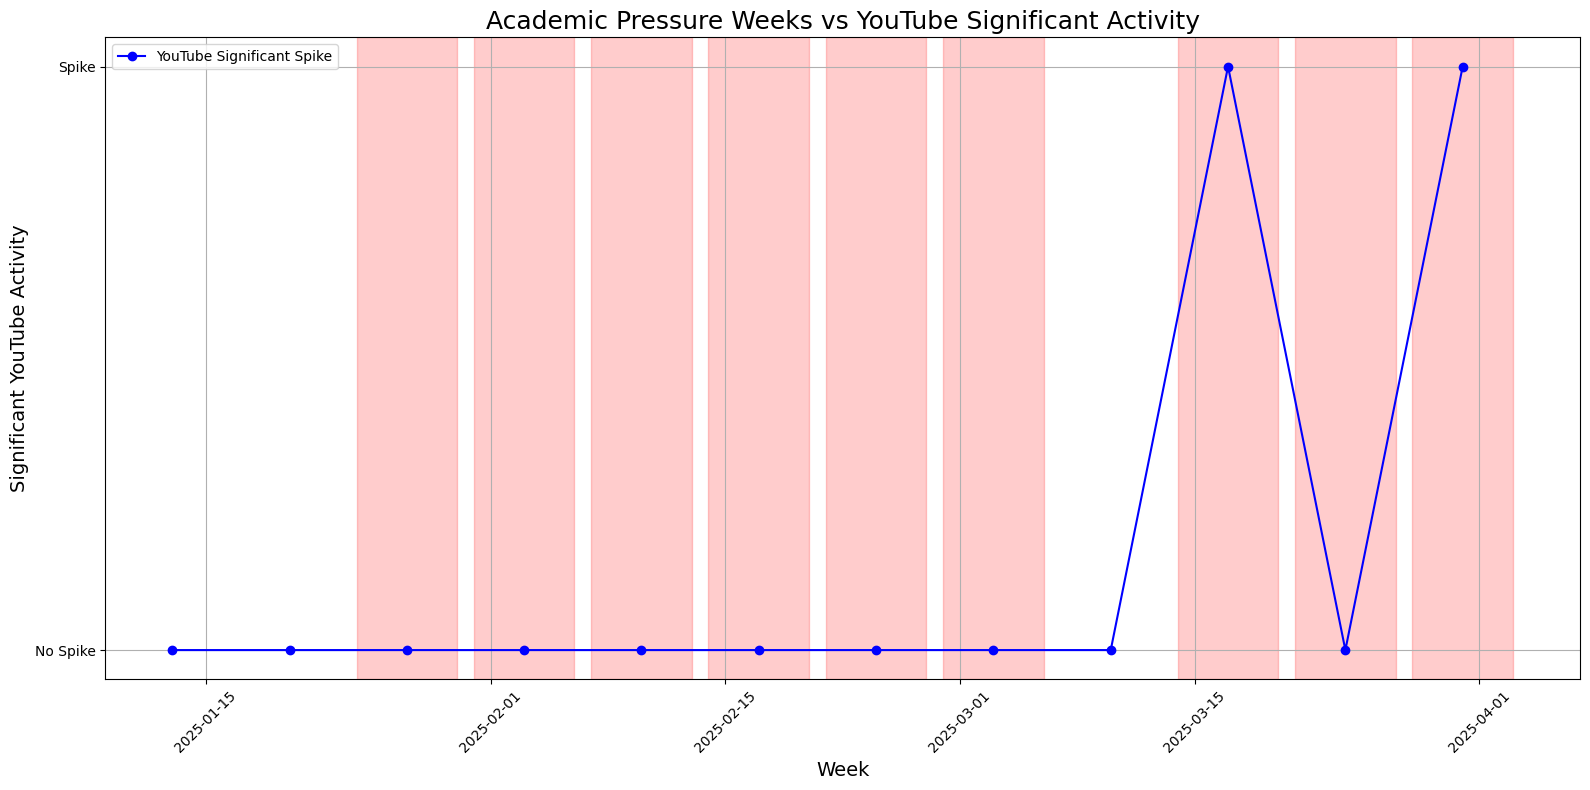

In [ ]:
import matplotlib.pyplot as plt

# Assume:
# combined['Week Start'] -> weekly timestamps
# combined['Academic Pressure Week'] -> 0/1
# youtube_weekly['significant_spike'] -> 0/1

plt.figure(figsize=(16, 8))

# Plot YouTube significant spikes
plt.plot(final_merged['Week Start'], final_merged['Significant Spike'], marker='o', color='blue', label='YouTube Significant Spike', linestyle='-')

# Highlight academic pressure weeks
for idx, row in final_merged.iterrows():
    if row['Academic Pressure Week'] == 1:
        plt.axvspan(row['Week Start'] - timedelta(days=3), row['Week Start'] + timedelta(days=3), color='red', alpha=0.2)

# Labels and stuff
plt.title('Academic Pressure Weeks vs YouTube Significant Activity', fontsize=18)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Significant YouTube Activity', fontsize=14)
plt.xticks(rotation=45)
plt.yticks([0, 1], ['No Spike', 'Spike'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


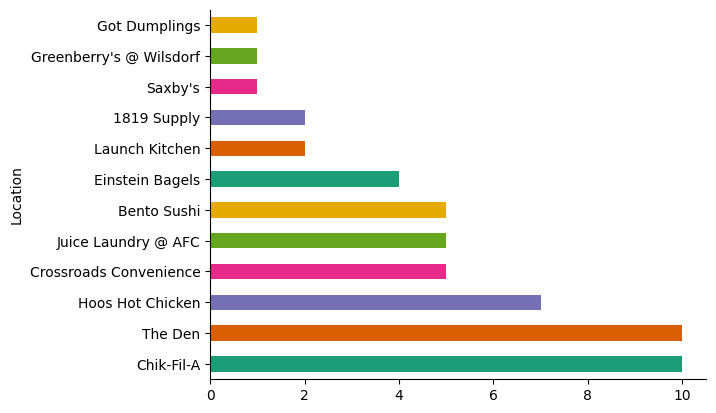

In [ ]:
# #@title Location vs count()
# from matplotlib import pyplot as plt
# import seaborn as sns

# locations = food_df['Location'].value_counts()
# locations.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)
